/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-12 17:07:43.348415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:07:43.949483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-12 17:07:43.949530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

device cuda:1
Finish initialization...
1123 (60000, 512)
1123 (60000, 512)


100%|██████████| 300/300 [00:00<00:00, 611.36it/s]
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:173: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1123 [0 0 0 1 0 0]
clean: 1 noise 0
Successfully load the DVI visualization model for iteration 43
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 1339

100%|██████████| 3200/3200 [00:03<00:00, 1042.50it/s]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 10

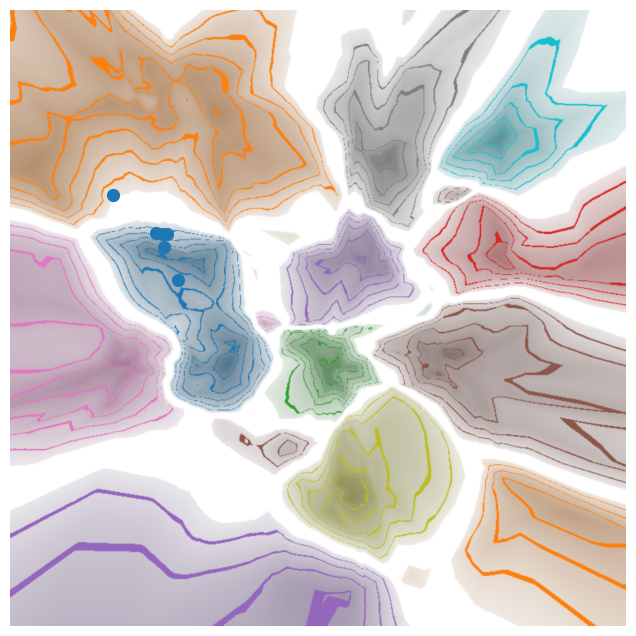

In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
sys.path.append('..')
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, DVILoss, DummyTemporalLoss
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import VISTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from trustVis.sampeling import CriticalSampling
from singleVis.spatial_edge_constructor import Trustvis_SpatialEdgeConstructor, TrustvisTemporalSpatialEdgeConstructor

from singleVis.utils import _construct_fuzzy_complex

from singleVis.projector import VISProjector

import torch.nn.functional as F
########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" #

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


parser = argparse.ArgumentParser(description='Process hyperparameters...')

# get workspace dir
current_path = os.getcwd()

parent_path = os.path.dirname(current_path)

new_path = os.path.join(parent_path, 'training_dynamic')




epoch = 53

CONTENT_PATH = '/home/yifan/dataset/case_study_mnist_backdoor'
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = epoch
EPOCH_END = epoch
# EPOCH_START = 1
# EPOCH_END = 50
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = 1
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = 0
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

# Define hyperparameters
GPU_ID = 1
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
print("device", DEVICE)           

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
PREPROCESS = 0
# data_provider._meta_adv_data()
if PREPROCESS:
    data_provider._meta_data()
    if B_N_EPOCHS >0:
        data_provider._gen_boundary(LEN // 10)    

# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)


# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)


VIS_MODEL_NAME = 'trustvis_tempo' ### saved_as VIS_MODEL_NAME.pth

# VIS_MODEL_NAME = 'base_dvi' ### saved_as VIS_MODEL_NAME.pth
# Define Projector
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 

vis = visualizer(data_provider, projector, 800, "tab10")


path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

epoch = 43
save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
print('1123',train_data.shape)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
print('1123',train_data.shape)
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)
print('1123',new_pred_Res[[492, 783, 835, 871, 951, 1052]])
print('clean:',clean_label[492], 'noise', noise_label[492])
emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
print('diff',diff[[[492, 783, 835, 871, 951, 1052,]]])
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=pred[indicates],
            train_labels=labels[indicates], 
            embedding=emb[indicates])



In [167]:
training_data_path = os.path.join(CONTENT_PATH, "Training_data")
training_data = torch.load(os.path.join(training_data_path, "training_dataset_data.pth"),
                                   map_location="cpu")

image1 = training_data[1]
image2 = training_data[2]
lamb = 0.5
image_mix = lamb * image1 + (1 - lamb) * image2

In [168]:
image_mix.shape

torch.Size([3, 32, 32])

In [169]:
import torchvision
train_dataset = torchvision.datasets.CIFAR10(root="data/cifar10", train=True, download=True)

Files already downloaded and verified


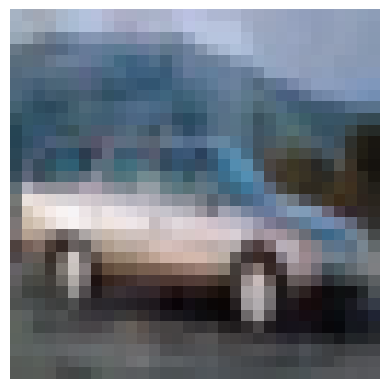

In [171]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
train_data = train_dataset.data
# 获取两个图像样本
image1 = train_data[1].astype(np.float32)  # 转换为浮点数
image2 = train_data[4].astype(np.float32)  # 转换为浮点数

lamb = 0.2  # 示例λ值

image_mix = lamb * image1 + (1 - lamb) * image2


image_mix = np.clip(image_mix, 0, 255).astype(np.uint8)

# 显示混合后的图像
plt.imshow(image_mix)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [172]:
from singleVis.utils import *
repr_model = data_provider.feature_function(epoch)
repr_model

training_data_path = os.path.join(CONTENT_PATH, "Training_data")
training_data = torch.load(os.path.join(training_data_path, "training_dataset_data.pth"),
                                   map_location="cpu")

image1 = training_data[1]
image2 = training_data[2]
image_mix = lamb * image1 + (1 - lamb) * image2

# 如果image_mix是PyTorch张量，则使用.permute()而不是.transpose()
image_mix = image_mix.permute(0, 1, 2).unsqueeze(0)  # 从 [32, 32, 3] 转换为 [1, 3, 32, 32]

# 确保数据类型为浮点数，并且在合适的设备上
image_mix_tensor = image_mix.to(DEVICE)

rep = net.feature(image_mix_tensor)  # 直接使用转换后的张量


In [173]:
emb_new_data = projector.batch_project(epoch, rep.detach().cpu().numpy())
emb_new_data

Successfully load the DVI visualization model for iteration 50


array([[-1.8361384,  6.4893165]], dtype=float32)

In [174]:
new_pred = data_provider.get_pred(epoch, rep.detach().cpu().numpy())
new_pred_Res = new_pred.argmax(axis=1)


100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


In [176]:

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)

labels = data_provider.train_labels(epoch)
print('1123',train_data.shape)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
print('1123',train_data.shape)
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
print('1123')

emb = projector.batch_project(epoch,train_data)
indicates = [1,4]
emb=emb[indicates]
pred=pred[indicates]
labels = labels[indicates]
emb = np.concatenate((emb,emb_new_data),axis=0)
pred = np.concatenate((pred,new_pred),axis=0)
labels = np.concatenate((labels,new_pred_Res),axis=0)
pred = pred.argmax(axis=1)

1123 (50000, 512, 1, 1)
1123 (50000, 512)


100%|██████████| 250/250 [00:00<00:00, 7501.03it/s]

1123
Successfully load the DVI visualization model for iteration 50


Successfully load the DVI visualization model for iteration 50
Computing decision regions ...
Successfully load the DVI visualization model for iteration 50
Successfully load the DVI visualization model for iteration 50
grid_samples (40000, 512)


100%|██████████| 200/200 [00:00<00:00, 8326.91it/s]


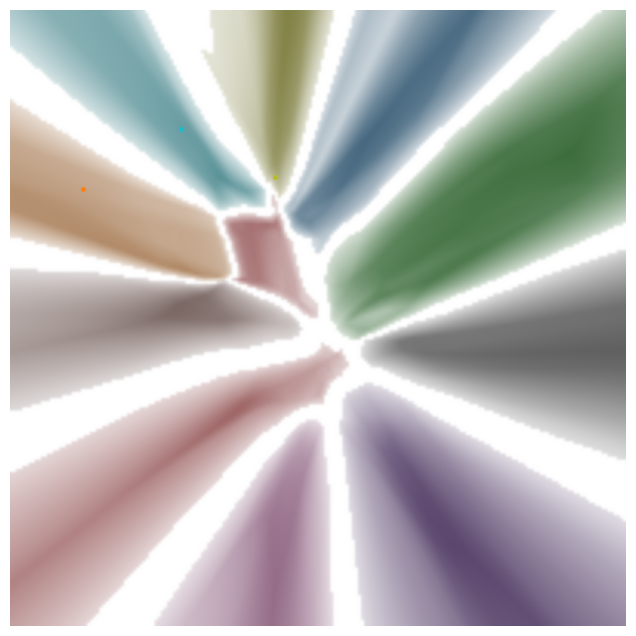

In [177]:
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=pred,
            train_labels=labels, 
            embedding=emb)